In [2]:
# from cond_rnn import ConditionalRNN
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
import pandas as pd
import math
import numpy as np

2022-09-23 11:31:19.664475: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-23 11:31:19.668810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/anaconda3-2021-05/lib:/cm/shared/apps/pbspro-ce/19.1.3/lib/
2022-09-23 11:31:19.668827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# import data
import pickle
with open("edmond_datasets.pickle", "rb") as handle:
    input_data_shiftedy = pickle.load(handle)
# select only n, daily asthma visits and total, daily total AE visits, 
# comment out if including air pollution station data
input_data_shiftedy = pd.concat([input_data_shiftedy.n.reset_index(drop = True), 
                        input_data_shiftedy.total.reset_index(drop = True)], axis = 1)

In [5]:
# number of time steps for sequence learning
n_steps_x = 14
# number of time steps for sequence prediction
n_steps_y = 7
def reshape_sliding1(X, num_steps_x = 7, num_steps_y = 7):
    X = pd.DataFrame(X)
    X_transformed = [np.array(X.shift(i)) for i in range(num_steps_x + num_steps_y)]
    X_transformed = np.dstack(X_transformed)
    
    # swap time steps and dimensionality axes
    X_transformed = np.swapaxes(X_transformed, 1, 2)
    X_transformed = X_transformed[(num_steps_x+num_steps_y):]
    return X_transformed

In [6]:
# scaling fit with train-test split consideration to avoid data leakage
# may need verification
from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
# fit by training set only
input_data_shiftedy.iloc[:(1800 + n_steps_x + n_steps_y),1:] = scaler.fit_transform(
    input_data_shiftedy.iloc[:(1800 + n_steps_x + n_steps_y),1:])
# only transform valid and testing sets
input_data_shiftedy.iloc[(1800 + n_steps_x + n_steps_y):,1:] = scaler.transform(
    input_data_shiftedy.iloc[(1800 + n_steps_x + n_steps_y):,1:])

In [7]:

input_data_shiftedy = reshape_sliding1(input_data_shiftedy, 
                                       num_steps_x = n_steps_x,
                                      num_steps_y = n_steps_y)

In [8]:
# train_test_split 

X_train = input_data_shiftedy[:1800, :n_steps_x, :-1]
X_valid = input_data_shiftedy[1800:2000, :n_steps_x, :-1]
X_test = input_data_shiftedy[2000:, :n_steps_x, :-1]

Y = np.empty((input_data_shiftedy.shape[0], n_steps_x, n_steps_y))
for step_ahead in range(1, n_steps_y + 1):
    Y[..., step_ahead - 1] = input_data_shiftedy[..., step_ahead:step_ahead + n_steps_x, 0]
Y_train = Y[:1800]
Y_valid = Y[1800:2000]
Y_test = Y[2000:]

In [9]:
# checking dimensionality
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
assert X_train.shape[1:] == X_valid.shape[1:]
assert Y_train.shape[1:] == Y_valid.shape[1:]

(1800, 14, 1) (1800, 14, 7) (200, 14, 1) (200, 14, 7)


# modelling
1. as of 23rd aug 2022: rnn loss nan problem <br>
possible remedies: normalize data, regularization, increase batch size <br>
https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan <br>
2. as of 24th aug 2022: try to add overall AE visit to include hospital avoidance effect
3. as of 25th aug 2022: corrected reshaping problem, performance is still shit, try remove air pollution, try larger learning rate
4. as of 26th aug 2022: try seq2seq model, it worked 
5. from the results it seems most contributing factor is total AE trend 


In [17]:
from tensorflow import keras
import tensorflow as tf

In [18]:
optimizer = keras.optimizers.Adam(clipvalue = 1)

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [20]:
# simplified wavenet
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [None, X_train.shape[2]]))
for rate in (1, 2, 4, 8, 16) * 2:
    model.add(keras.layers.Conv1D(filters = 20, kernel_size = 2, padding = "causal",
                                 activation = "relu", dilation_rate = rate))
model.add(keras.layers.Conv1D(filters = Y_train.shape[2], kernel_size = 1))
model.compile(loss = "mse", optimizer = optimizer, metrics = [last_time_step_mse])

2022-09-08 13:37:23.243510: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-08 13:37:23.243540: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hpc-hn001): /proc/driver/nvidia/version does not exist
2022-09-08 13:37:23.244198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid),
                    callbacks = [callback]
                   )

Epoch 1/20
57/57 [==============================] - 2s 9ms/step - loss: 1119.9030 - last_time_step_mse: 1134.3983 - val_loss: 118.9650 - val_last_time_step_mse: 117.6306
Epoch 2/20
57/57 [==============================] - 0s 4ms/step - loss: 296.0925 - last_time_step_mse: 240.0852 - val_loss: 28.1490 - val_last_time_step_mse: 24.1537
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 67.5104 - last_time_step_mse: 60.0591 - val_loss: 25.3051 - val_last_time_step_mse: 23.1792
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 61.1432 - last_time_step_mse: 57.3919 - val_loss: 24.1901 - val_last_time_step_mse: 22.3600
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 60.0985 - last_time_step_mse: 56.2224 - val_loss: 24.2902 - val_last_time_step_mse: 21.7139
Epoch 6/20
57/57 [==============================] - 0s 4ms/step - loss: 60.3336 - last_time_step_mse: 56.6127 - val_loss: 24.3177 - val_last_time_step_mse: 22.0085
Epoch 7/

In [22]:
# inference 
import matplotlib.pyplot as plt

In [23]:
pred = model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [24]:
assert pred.shape == Y_test.shape

In [25]:
pred[:,:,-1].flatten()

array([ 9.966289, 15.505464, 16.487354, ..., 27.130516, 26.027449,
       25.29409 ], dtype=float32)

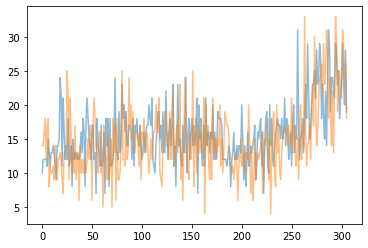

In [26]:
plt.plot(np.rint(pred[:, 0, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_test[:, 0, -1]).flatten(), alpha = .5)

In [27]:
pred = model.predict(X_valid)

7/7 [==============================] - 0s 2ms/step


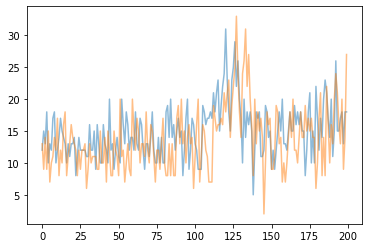

In [28]:
plt.plot(np.rint(pred[:, 0, -1]).flatten(), alpha = .5)
plt.plot(np.rint(Y_valid[:, 0, -1]).flatten(), alpha = .5)

In [36]:
from sklearn.metrics import mean_squared_error

mse = (mean_squared_error((pred[:, 0, -1]).flatten(), Y_valid[:, 0, -1]).flatten())
print('Test MSE: %.3f' % mse)

Test MSE: 29.236
